In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score

## Data Preparation

In [2]:
# Define training and testing data paths
train_dir = 'archive/Training'
test_dir = 'archive/Testing'

# Load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),  # Resize all images to 256x256
    batch_size=32,
    label_mode='int',
    shuffle=True
)

# Load test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    label_mode='int',
    shuffle=False           # No need to shuffle test data
)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [3]:
class_names = train_ds.class_names
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [4]:
# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.2),  # Rotate by a max of 20%
    tf.keras.layers.RandomZoom(0.15),     # Zoom by a max of 15%
])

# Augment and prefetch the datasets
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Selection

In [5]:
# Setup the model layers for the Convolutional Neural Network (CNN) model
model = tf.keras.models.Sequential([
    # Scans the images with 32 filters to detect patterns with Leaky ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(),                 # Reduces feature map size by selecting the most important information
    tf.keras.layers.Flatten(),                      # Flattens the 2D feature maps into a 1D array
    # Fully connected layer with 256 neurons and Leaky ReLU activation
    tf.keras.layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 output neurons for class probabilities using softmax
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"]
)

## Model Training

In [ ]:
# Create callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

# Train the model
model.fit(train_ds, validation_data=test_ds, epochs=50, callbacks=[early_stopping])

## Model Deployment

In [6]:
model.save("models/trained_model")
# model = tf.keras.models.load_model("models/trained_model")

## Evaluations and Results

In [7]:
# Evaluate model on training data
model.evaluate(train_ds, verbose=1)

90/90 [==============================] - 20s 213ms/step - loss: 0.1170 - accuracy: 0.9944


[0.11704982072114944, 0.9944250583648682]

In [8]:
# Show the model's accuracy, precision, recall, and loss on testing data

# Unbatch the testing dataset
images = []
labels = []

for image, label in test_ds.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)

# Evaluate model
loss, accuracy = model.evaluate(test_ds)

# Make predictions
predictions = model.predict(test_ds)
predicted_labels = tf.argmax(predictions, axis=1)

# Compute precision and recall
recall = recall_score(labels, predicted_labels, average="micro")
precision = precision_score(labels, predicted_labels, average='micro')

# Show metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Loss: {loss}')

13/13 [==============================] - 3s 189ms/step
Accuracy: 0.7639594078063965
Precision: 0.7639593908629442
Recall: 0.7639593908629442
Loss: 96.162109375


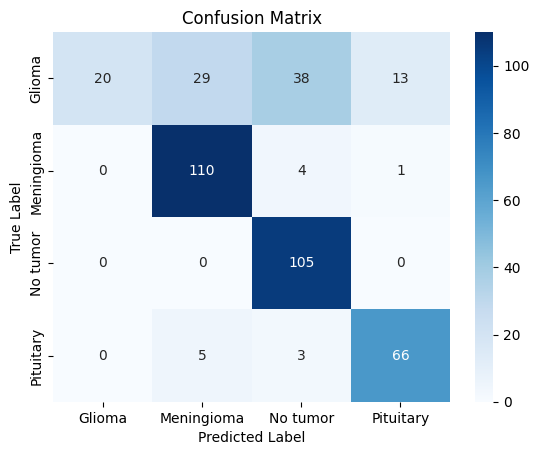

In [9]:
# Generate confusion matrix
cm = confusion_matrix(labels, predicted_labels)

# Plotting confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'], 
            yticklabels=['Glioma', 'Meningioma', 'No tumor', 'Pituitary'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()